In [3]:
#coding:utf-8
import sys
import pandas as pd
import pickle
import tensorflow as tf
import collections
import numpy as np
import glob
from functools import reduce
from keras.preprocessing.text import one_hot
from keras.layers import Input, LSTM, Dense, merge,concatenate,Embedding,Masking, Flatten,TimeDistributed,dot,Activation
from keras.optimizers import Adam, SGD
from keras.models import Model,load_model,Sequential
from tensorflow.keras.utils import plot_model, to_categorical
import matplotlib.pyplot as plt
import re
import os

In [4]:
#read data
df = pd.read_pickle("train_data.pkl")

In [5]:
#data that splitted by "，", "。", "\n"
df

,inputs,targets
0,本港連續第三日冇出現不明源頭感染,\t本港連續第三天沒有出現不明源頭感染\n
1,新增十五宗新冠病毒確診,\t新增十五宗新冠病毒確診\n
2,只係有一宗本地個案,\t只是有一宗本地個案\n
3,同早前嘅確診個案有關連,\t和早前的確診個案有關連\n
4,新增嘅本地感染個案,\t新增的本地感染個案\n
...,...,...
10972,單係今年登記嘅新工會,\t單是今年登記的新工會\n
10973,至少亦都有四百一十七個,\t至少也有四百一十七個\n
10974,選舉將會喺今個月二十一號舉行,\t選舉將會在本月二十一日舉行\n
10975,選出五名個勞方代表就勞工法例等相關事宜,\t選出五名個勞方代表就勞工法例等相關事宜\n


In [6]:
#Get lists
#we don't have strong GPU and computational power
#use 6500 samples (60%) to test out model first
input_texts=df.inputs[0:6500,].values.tolist()
target_texts=df.targets[0:6500,].values.tolist()
NUM_SAMPLES=len(input_texts)

In [7]:
def create_model_attention(n_in,n_out,n_units):
    
    #input of encoder and apply masking of "0"
    #the input of encoder is the cantonese word
    encoder_in = Input(shape = (None,))
    enc_emb =  Embedding(input_dim=n_in, output_dim=n_units,mask_zero=True)(encoder_in)
    
    #train LSTM with encoder input (encoder_in)
    #get the encoder output (encoder_out), hidden state (encoder_h) and cell state (encoder_c)
    encoder = LSTM(n_units, return_sequences=True, return_state=True)
    encoder_out,encoder_h,encoder_c = encoder(enc_emb)
    encoder_state = [encoder_h,encoder_c]
    
    #input of decoder and apply masking of "0"
    #the input of decoder is the chinese word
    decoder_in = Input(shape = (None,))
    dec_emb_layer = Embedding(input_dim=n_out, output_dim=n_units,mask_zero=True)
    dec_emb = dec_emb_layer(decoder_in)
    
    #train LSTM using decoder input (decoder_in), hidden state (encoder_h) and cell state (encoder_c) of encoder
    #get the decoder output (decoder_out), give up the hidden state and cell state of decoder
    decoder = LSTM(n_units,return_sequences=True, return_state=True)
    decoder_out, _, _ = decoder(dec_emb,initial_state=encoder_state)
    
    #apply attention to the encoder output and decoder output, generate new decoder output using the context vector
    attention = dot([decoder_out, encoder_out], axes=[2, 2])
    attention = Activation('softmax')(attention)
    context = dot([attention, encoder_out], axes=[2,1])
    decoder_out = concatenate([context, decoder_out])
    
    #dense layer
    decoder_dense = Dense(n_out,activation='softmax')
    decoder_out = decoder_dense(decoder_out)
    
    #create the model
    #fit with the true decoder output
    model = Model([encoder_in,decoder_in],decoder_out)
    
    #create inference model of encoder
    #fit the encoder input to the encoder output and encoder state
    encoder_infer = Model(encoder_in,[encoder_out] + encoder_state)
    
    #inference model of decoder
    #receive the encoder output (encoder_infer_out), hidden state (decoder_state_in_h) and cell state (decoder_state_in_c)
    #the three input pass from the encoder_infer
    decoder_state_in_h = Input(shape=(n_units,))
    decoder_state_in_c = Input(shape=(n_units,))
    encoder_infer_out = Input(shape=(None,n_units))
    
    #initial state of decoder
    decoder_state_in = [decoder_state_in_h, decoder_state_in_c]
    
    #receive the decoder infer input (decoder_in_single) and apply masking of "0"
    #which is a single word as we are no more training but predicting with inference model and the input cantonese
    decoder_in_single = Input(shape=(None,))
    decoder_in_single_emb = dec_emb_layer(decoder_in_single)
    
    #train LSTM using decoder infer input (decoder_in_single_emb), hidden state (decoder_state_in_h) and cell state (decoder_state_in_c) of encoder infer
    decoder_infer_out, decoder_infer_state_h, decoder_infer_state_c = decoder(decoder_in_single_emb,initial_state=decoder_state_in)
    
    #apply attention to the encoder infer output and decoder infer output, generate new decoder infer output using the context vector
    decoder_infer_state = [decoder_infer_state_h, decoder_infer_state_c]
    attention_infer = dot([decoder_infer_out, encoder_infer_out], axes=[2, 2])
    attention_infer = Activation('softmax')(attention_infer)
    context_infer = dot([attention_infer, encoder_infer_out], axes=[2,1])
    decoder_infer_out = concatenate([context_infer, decoder_infer_out])
    
    #dense layer
    decoder_infer_out = decoder_dense(decoder_infer_out)
    
    #create inference model of decoder
    #using .predict to do the translation
    decoder_infer = Model([decoder_in_single, encoder_infer_out]+decoder_state_in,[decoder_infer_out]+decoder_infer_state)
   
    return model, encoder_infer, decoder_infer

In [8]:
#check unique word in each text
input_characters = sorted(list(set(df.inputs[0:6500,].unique().sum())))
target_characters = sorted(list(set(df.targets[0:6500,].unique().sum())))

#get the maximum length of input and output
INPUT_LENGTH = max([len(i) for i in input_texts])
OUTPUT_LENGTH = max([len(i) for i in target_texts])

#get the feature length of input and output
INPUT_FEATURE_LENGTH = len(input_characters)
OUTPUT_FEATURE_LENGTH = len(target_characters)

#building the dictionary with the unique word
input_dict = {char:index+1 for index,char in enumerate(input_characters)}
input_dict_reverse = {index+1:char for index,char in enumerate(input_characters)}
target_dict = {char:index+1 for index,char in enumerate(target_characters)}
target_dict_reverse = {index+1:char for index,char in enumerate(target_characters)}


In [9]:
encoder_input = np.zeros((NUM_SAMPLES,INPUT_LENGTH))
decoder_input = np.zeros((NUM_SAMPLES,OUTPUT_LENGTH))
decoder_output = np.zeros((NUM_SAMPLES,OUTPUT_LENGTH))

#integer encoding to encoder input and decoder input
#where the final output should be one hot encoding (recall LSTM)
for seq_index,seq in enumerate(input_texts):
    for char_index, char in enumerate(seq):
        encoder_input[seq_index,char_index] = input_dict[char]
for seq_index,seq in enumerate(target_texts):
    for char_index,char in enumerate(seq):
        decoder_input[seq_index,char_index] = target_dict[char]
        if char_index > 0:
            decoder_output[seq_index,char_index-1] = target_dict[char]

#one hot encoding to the decoder output as the output of model should be three dimension (recall LSTM)
decoder_target_matrix = to_categorical(decoder_output, OUTPUT_FEATURE_LENGTH+1)

In [10]:
#define unit and batch size
N_UNITS=256
BATCH_SIZE=64

#create model
model_train, encoder_inference, decoder_inference = create_model_attention(INPUT_FEATURE_LENGTH+1, OUTPUT_FEATURE_LENGTH+1, N_UNITS)

In [11]:
#summary of model
model_train.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    559360      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    554752      input_2[0][0]                    
______________________________________________________________________________________________

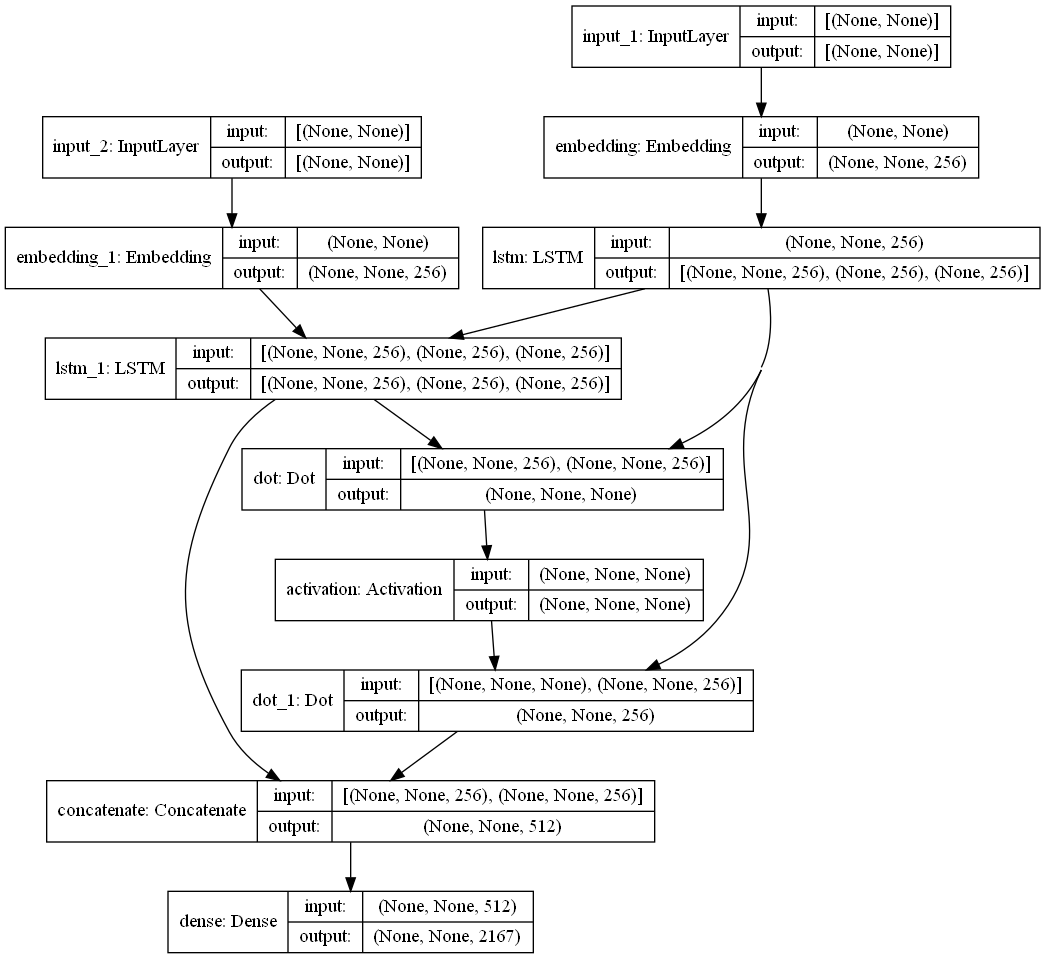

In [12]:
#plot of the model
#plot_model(model=model_train,show_shapes=True)

In [13]:
#optimizer and loss function of model
model_train.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint_path = "cp-train.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [50]:
history=model_train.fit([encoder_input,decoder_input],decoder_target_matrix,batch_size=BATCH_SIZE,epochs=20,shuffle = True,verbose=2,callbacks=[cp_callback],validation_split=0.2)

Epoch 1/20
82/82 - 132s - loss: 0.0639 - accuracy: 0.9411 - val_loss: 0.3725 - val_accuracy: 0.6820

Epoch 00001: saving model to cp-train.ckpt
Epoch 2/20
82/82 - 145s - loss: 0.0519 - accuracy: 0.9536 - val_loss: 0.3653 - val_accuracy: 0.6918

Epoch 00002: saving model to cp-train.ckpt
Epoch 3/20
82/82 - 130s - loss: 0.0428 - accuracy: 0.9626 - val_loss: 0.3595 - val_accuracy: 0.6955

Epoch 00003: saving model to cp-train.ckpt
Epoch 4/20
82/82 - 136s - loss: 0.0351 - accuracy: 0.9703 - val_loss: 0.3616 - val_accuracy: 0.6999

Epoch 00004: saving model to cp-train.ckpt
Epoch 5/20


KeyboardInterrupt: 

In [14]:
model_train.load_weights("cp-train.ckpt")

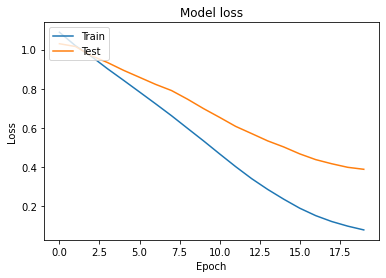

In [49]:
"""plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()"""

In [15]:
def predict_chinese(source,encoder_inference, decoder_inference, n_steps, features):
    encoder_output, h, c = encoder_inference.predict(source)
    state = [h, c]
    predict_seq = np.zeros((1, 1))
    predict_seq[0,0] = target_dict['\t']
    output = []

    output = ''
    for i in range(n_steps):
        decode,h,c = decoder_inference.predict([predict_seq,encoder_output]+state)
        char_index = np.argmax(decode[0,0,:])
        char = target_dict_reverse[char_index]
        output += char
        predict_seq[0,0] = char_index
        state = [h,c]
        if char == '\n':
            break
    return output

In [ ]:
import random
for i in range(0,200):
    z=random.randint(0,6499) 
    test = encoder_input[z:z+1]
    out = predict_chinese(test,encoder_inference,decoder_inference,OUTPUT_LENGTH,OUTPUT_FEATURE_LENGTH+1)
    print(input_texts[z])
    print(out)

總數九個人
總數九個人

前學生動源召集人鍾翰林
前學生動源召集人鍾翰林

就早啲囉
就早一些

四個被取消資格嘅議員
四個被取消資格的議員

」李慧琼：「議員我認為你離題
」李慧琼：「議員我認為你離題

存放有待銷毀嘅服務紀錄
有放緩銷毀的服務紀錄

如果你有五個中嘅
如果你有五個中的

政府總部在內嘅五千個公營場所
政府總部在內的五千個公營所

學校會停課三日
學校會停課三天

上水屠房就多5人感染
上棟樓就多數人感染

只有會員、新聞業界朋友、大專學界新聞系嘅老師同學生可以參加
只有會員、新聞業界朋友、大專學界新聞系的老師及學生可以參加

話檢視控方證供同徵詢律師意見之後
指若建控方證供應及病徵見見之後

直到午夜十二點四十六分
直到午夜十二時四十六分

用閃光彈呀
用閃光彈

如果唔理或者拒絕交番聲明
如果不理或拒絕交回聲明

政府將會公布身處廣東同澳門嘅港人
政府將會公布身處廣東同澳門的港人

警方國安處喺元朗拘捕前學生動源成員陸海天
警方國安處在元朗拘捕前學生動源成員陸海天

再初步確診
再到初步確診

至於公共交通
至於公共交通

我覺得都好難講佢符合資格參選立法會
我覺得都很難說他符合資格參選立法會

否則政治參與權利會遭到剝奪
否則政治參與權利會遭到剝奪

刪除四名被取消資格嘅議員提出嘅十一項議案
議案被撤名消取消資格的議員提出的十一項議案

好難講呢啲患者係點樣感染到
很難說這些患者是怎樣找到

優先投票；亦都會為電子選民登記冊、即係之後入票站攞票嘅時候
優先投票；亦會為電子選民登記冊、即是電後入票站

不過都諗唔到咁多人
不過都不到這麼多人人

其實呢都係要作出一啲決定
其實都是要作出一些決定

或者剩嘅
或者的

抽血啦
了了

為咗上京
為了上京

我相信未必係一個明智之舉囉
我相信未必是一個明智之舉吧

憂慮將來議員即使完成宣誓
憂慮將來議員即使完成宣誓

希望政府交代具體推行時間同澄清計劃嘅實際開支
希望政府交代具體推行時間和澄清計和及清清支支

因為我們完全理解到我地嘅朋友係很好重視私隱
因為我們完全理解到我們的朋友是很重視私隱

咁樣係嚴重違背法律嘅程序
那麼嚴重違背法律的程序

我地嘅教學將會變得非常之沉悶
我們的教學將會變得非常悶

恢復法治同秩序
法治及介序特別

未決定會唔會尋求司法覆核
未決定會不會尋求司法覆核

咁市民呢

In [74]:
tests='你係唔係人'
abc = np.zeros((1,INPUT_LENGTH))
for char_index, char in enumerate(tests):
    abc[0,char_index] = input_dict[char]
out = predict_chinese(abc,encoder_inference,decoder_inference,OUTPUT_LENGTH,OUTPUT_FEATURE_LENGTH+1)
print(tests)
print(out)

發牌
發發

